# AutoBacktest
Given a specific ticker, will return the backtest results of using Facebook Prophet as a trading strategy.

In [1]:
# Libraries
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import numpy as np
import plotly.express as px
from prophet import Prophet
import yfinance as yf

# Get Price Data

In [32]:
def getStockPrices(stock, n_days, training_days, mov_avg):
    """
    Gets stock prices from now to N days ago and training amount will be in addition 
    to the number of days to train.
    """
    
    # Designating the Ticker
    ticker = yf.Ticker(stock)

    # Getting all price history
    prices = ticker.history(period="max")
    
    # Check on length
    if len(prices)<n_days+training_days+mov_avg:
        return pd.DataFrame()
    
    # Getting relevant length
    prices = prices.tail(n_days+training_days+mov_avg)
        
    # Filling NaNs with the most recent values for any missing data
    prices = prices.fillna(method='ffill')
    
    # Getting the N Day Moving Average and rounding the values for some light data preprocessing
    prices['MA'] = prices[['Close']].rolling(
        window=mov_avg
    ).mean().apply(lambda x: round(x, 2))

    # Resetting format for FBP
    prices = prices.reset_index().rename(
        columns={"Date": "ds", "MA": "y"}
    )
    
    # Dropping the Nans
    prices.dropna(inplace=True, subset=['y'])
    
    return prices

In [26]:
def fbpTrainPredict(df, forecast_period):
    """
    Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
    the future based on given forecast period. Returns predicted values as a DF.
    """
    # Setting up prophet
    m = Prophet(
        daily_seasonality=True, 
        yearly_seasonality=True, 
        weekly_seasonality=True
    )
    
    # Fitting to the prices
    m.fit(df[['ds', 'y']])
    
    # Future DF
    future = m.make_future_dataframe(
        periods=forecast_period,
        freq='B',
        include_history=False
    )
            
    # Predicting values
    forecast = m.predict(future)

    # Returning a set of predicted values
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [4]:
def runningFBP(prices, forecast_period, training_days):
    """
    Runs Facebook Prophet to get predictions over a set period 
    of time. Uses FBP to train and predict every N days and gets the 
    price forecasts.
    """
    # DF for the predicted values
    pred_df = pd.DataFrame()

    # Running the model each day
    for i in tqdm(range(training_days, len(prices)+1)):
        
        # Training and Predicting the last day on the forecast
        forecast = fbpTrainPredict(
            prices[i-training_days:i], 
            forecast_period
        ).tail(1)
        
        # Adding the forecast predicted
        pred_df = pred_df.append(forecast, ignore_index=True)
        
    # Prepping for merge by converting date values to be the same type
    pred_df['ds'] = pred_df['ds'].apply(lambda x: str(x)[:10])

    prices['ds'] = prices['ds'].apply(lambda x: str(x)[:10])
    
    # Shifting the forecasts back in order to compare it to the 'current' open values
    pred_df[['yhat', 'yhat_lower', 'yhat_upper']] = pred_df[['yhat', 'yhat_lower', 'yhat_upper']].shift(-forecast_period)
    
    # Merging with the prices DF in order to compare values for positions later
    merge_df = prices[['ds', 'Open']].merge(
        pred_df,
        on='ds',
        how='outer'
    ).dropna().set_index('ds')

    return merge_df

In [5]:
# Pricing Data Parameters
n_days = 365

training_days = 200

mov_avg = 5

forecast_period = 5

# Retrieving prices with the above parameters
prices = getStockPrices(
    "TSLA", 
    n_days=n_days,
    training_days=training_days, 
    mov_avg=mov_avg
)

In [493]:
# Running Facebook Prophet with the set parameters
pred_df = runningFBP(
    prices, 
    forecast_period, 
    training_days
)

100%|██████████| 367/367 [03:03<00:00,  2.00it/s]


# Getting Positions

In [6]:
def fbpPositions(pred_df, short=True):
    """
    Gets positions based on the predictions and the actual values.
    """
    if pred_df['Open'] < pred_df['yhat_lower']:
        return 1
    elif pred_df['Open'] > pred_df['yhat_upper'] and short:
        return -1
    else:
        return 0

In [7]:
# Adding sentiment positions to the forecast DF
positions = pred_df

# Getting forecast prophet positions
positions['fbp_positions'] = positions.apply(
    lambda x: fbpPositions(x, short=True), 
    axis=1
)

# Buy and hold position
positions['buy_hold'] = 1

NameError: name 'pred_df' is not defined

# Backtest

In [502]:
# Getting daily returns
log_returns = prices[['ds', 'Close']].set_index(
    'ds'
).loc[positions.index].apply(np.log).diff()

In [503]:
# The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
bt_positions = positions[[
    'buy_hold', 
    'fbp_positions'
]].shift(1)

# The returns during the backtest
returns = bt_positions.multiply(
    log_returns['Close'], 
    axis=0
)

# Inversing the log returns to get daily portfolio balance
performance = returns.cumsum().apply(
    np.exp
).dropna().fillna(
    method='ffill'
)

# Calculating Backtest Performance

In [8]:
def riskAnalysis(performance):
    """
    Analyzes the performance DataFrame to calculate various
    evaluation metrics on the backtest to determine if
    the backtest performance was favorable.
    """

    # Ending portfolio balance
    bal = performance.tail(1)
    
    # Largest percent drop (drawdown) in a 10 day timeframe
    loss = performance.pct_change(10).min()

    # Average returns in a 10 day timeframe
    avg_ret = performance.pct_change(10).mean()
    
    # Performance score
    score = 0
    
    # Checking ending portfolio balance
    if bal['fbp_positions'][0]>bal['buy_hold'][0] and bal['fbp_positions'][0]>1.33: score += 2
        
    # Comparing the largest losses
    if loss['fbp_positions']>loss['buy_hold']: score += 1
        
    # Comparing the average returns    
    if avg_ret['fbp_positions']>avg_ret['buy_hold']: score += 1
                
    if score>=3:
                
        return {
            "result": True,
            "score": score,
            "endingBalance": {
                "prophet": bal['fbp_positions'][0],
                "buyHold": bal['buy_hold'][0]
            },
            "largestLoss": {
                "prophet":loss['fbp_positions'],
                "buyHold":loss['buy_hold']
            },
            "averageReturn": {
                "prophet":avg_ret['fbp_positions'],
                "buyHold":avg_ret['buy_hold']
            }
        }

    else:
        return {
            "result": False,
            "score": score,
            "endingBalance": {
                "prophet": bal['fbp_positions'][0],
                "buyHold": bal['buy_hold'][0]
            },
            "largestLoss": {
                "prophet":loss['fbp_positions'],
                "buyHold":loss['buy_hold']
            },
            "averageReturn": {
                "prophet":avg_ret['fbp_positions'],
                "buyHold":avg_ret['buy_hold']
            }
        }

In [505]:
riskAnalysis(performance)

{'result': True,
 'score': 4,
 'endingBalance': {'prophet': 2.3689646697330846,
  'buyHold': 1.9902420553950548},
 'largestLoss': {'prophet': -0.17672495095931806,
  'buyHold': -0.279406106749888},
 'averageReturn': {'prophet': 0.03264528143373008,
  'buyHold': 0.027063907542224437}}

# Visualization

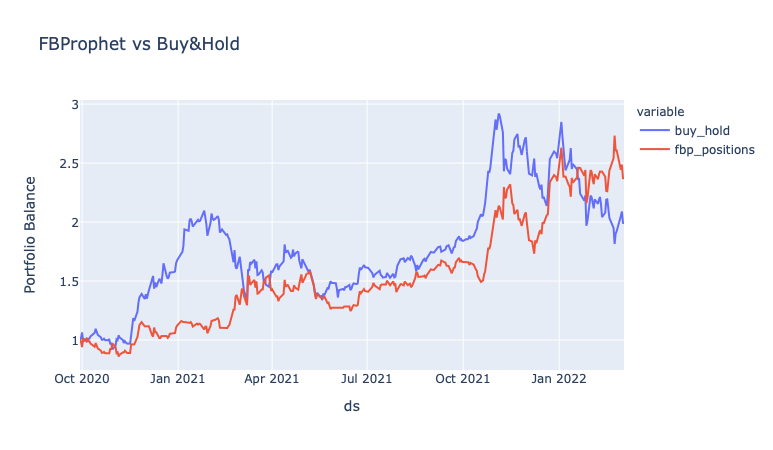

In [506]:
# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='FBProphet vs Buy&Hold',
    labels={"value": "Portfolio Balance",
            "index": "Date"}
)

fig.show()

# Consolidating Backtest Functions

In [27]:
def backtestStock(stock, pred_df, prices, inverse_pos=False):
    
    # Adding sentiment positions to the forecast DF
    positions = pred_df

    # Getting forecast prophet positions (inversing if needed)
    if inverse_pos:
        
        positions['fbp_positions'] = positions.apply(
            lambda x: -(fbpPositions(x, short=True)), 
            axis=1
        )
        
    else:
        positions['fbp_positions'] = positions.apply(
            lambda x: fbpPositions(x, short=True), 
            axis=1
        )

    # Buy and hold position
    positions['buy_hold'] = 1
    
    # Getting daily returns
    log_returns = prices[['ds', 'Close']].set_index(
        'ds'
    ).loc[positions.index].apply(np.log).diff()
    
    # The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
    bt_positions = positions[[
        'buy_hold', 
        'fbp_positions'
    ]].shift(1)

    # The returns during the backtest
    returns = bt_positions.multiply(
        log_returns['Close'], 
        axis=0
    )

    # Inversing the log returns to get daily portfolio balance
    performance = returns.cumsum().apply(
        np.exp
    ).dropna().fillna(
        method='ffill'
    )
    
    # Performing risk analysis
    risk = riskAnalysis(performance)
    
    # Retrying the backtest but with inversed prophet positions
    if risk['result']==False and inverse_pos==False:
        
        print("retrying backtest with inversed positions")
        
        return backtestStock(
            stock, 
            pred_df,
            prices,
            inverse_pos=True
        )
        
    
    # Visualizing results
    fig = px.line(
        performance,
        x=performance.index,
        y=performance.columns,
        title=f'FBProphet vs Buy&Hold for {stock}',
        labels={"value": "Portfolio Balance",
                "index": "Date"}
    )

    fig.show()
    
    if inverse_pos:
        
        return {
            "backtestResult": risk['result'],
            "inversePosition": -1
        }
    
    else:
        
        return {
            "backtestResult": risk['result'],
            "inversePosition": 1
        }

# Getting Stock and Backtest

In [33]:
def getStockAndBacktest(stock, n_days, training_days, mov_avg, forecast_period):
    
    # Printing the stock
    print(f"Backtesting {stock}. . .")

    # Retrieving prices with the given parameters
    prices = getStockPrices(
        stock, 
        n_days=n_days,
        training_days=training_days, 
        mov_avg=mov_avg
    )
    
    if prices.empty:
        print(f"Not enough price history for {stock}; skipping backtest...")
        return
    
    # Running Facebook Prophet with the set parameters
    pred_df = runningFBP(
        prices, 
        forecast_period=forecast_period, 
        training_days=training_days
    )
        
    # Running backtest
    backtest = backtestStock(stock, pred_df, prices, inverse_pos=False)
    
    if backtest['backtestResult']:
        print(f"{stock} backtest results were positive!")
        
        # Run Prophet for current prediction
        preds = fbpTrainPredict(
            prices.tail(training_days), 
            forecast_period
        ).tail(1)
        
        preds['Open'] = prices.tail(1)['Open'].values
                
        # Getting forecast prophet positions
        trade_decision = fbpPositions(preds.to_dict('records')[0], short=True) * backtest['inversePosition']
        
        trade_dict = {
            1 : f"Buy {stock}",
            0 : f"Exit {stock}/Do nothing",
            -1: f"Short {stock}"
        }
        
        print(trade_dict[trade_decision])
                
        return trade_dict[trade_decision]
        
    else:
        print(f"Negative backtest results for {stock}.")
        return 
    

Backtesting AAPL. . .


100%|██████████| 367/367 [03:04<00:00,  1.98it/s]

retrying backtest with inversed positions


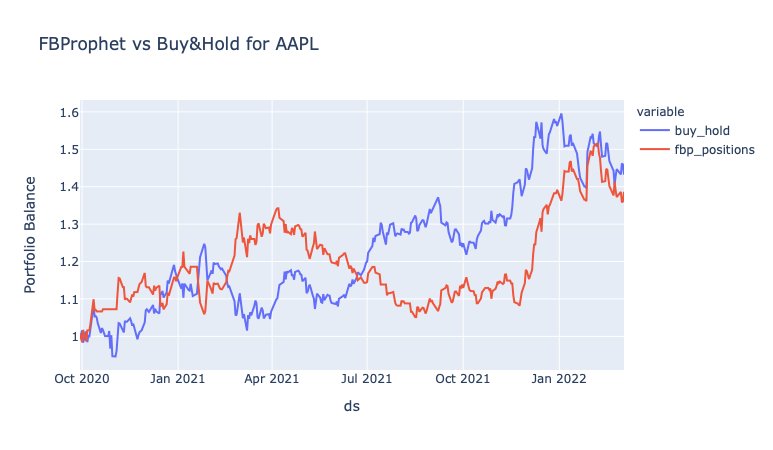

  0%|          | 0/367 [00:00<?, ?it/s]

Negative backtest results for AAPL.
Backtesting TSLA. . .


100%|██████████| 367/367 [03:04<00:00,  1.99it/s]


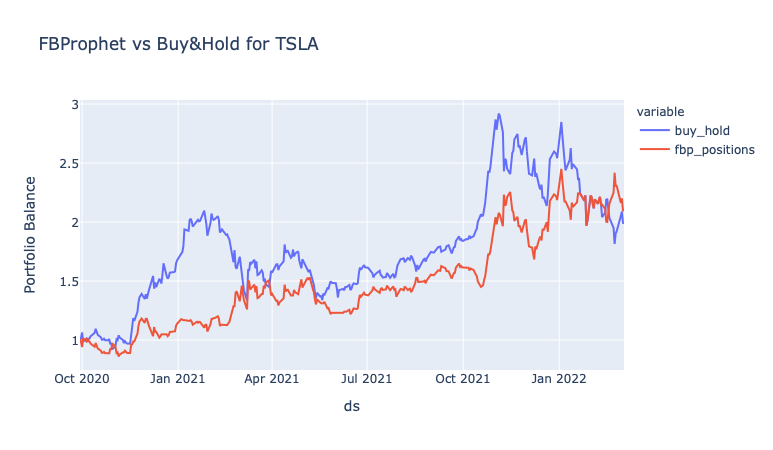

TSLA backtest results were positive!
Buy TSLA
Backtesting AMD. . .


100%|██████████| 367/367 [03:05<00:00,  1.98it/s]

retrying backtest with inversed positions


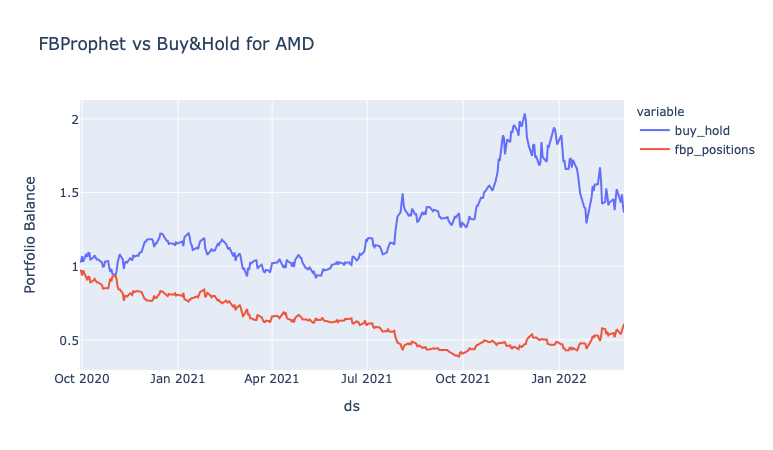

  0%|          | 0/367 [00:00<?, ?it/s]

Negative backtest results for AMD.
Backtesting AAL. . .


100%|██████████| 367/367 [03:03<00:00,  2.00it/s]

retrying backtest with inversed positions


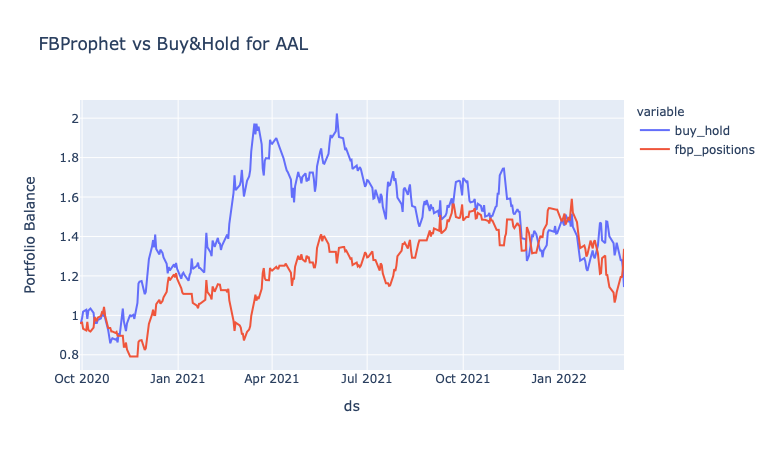

Negative backtest results for AAL.
Backtesting BAC. . .


100%|██████████| 367/367 [03:06<00:00,  1.97it/s]

retrying backtest with inversed positions


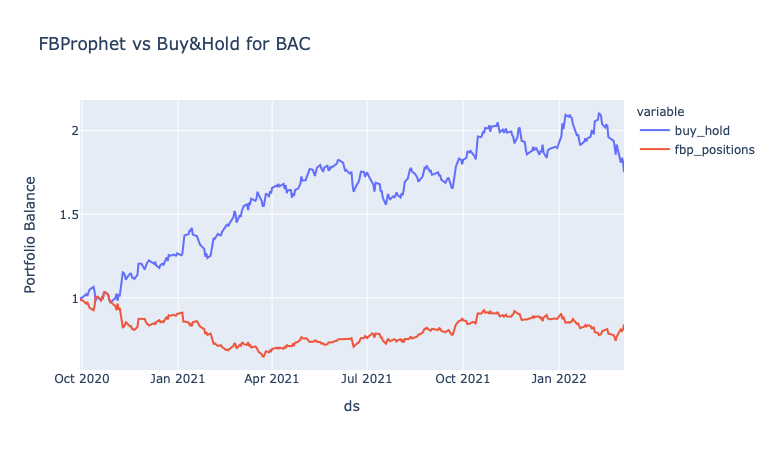

Negative backtest results for BAC.


In [34]:
for i in ["AAPL", "TSLA", "AMD", "AAL", "BAC"]:

    getStockAndBacktest(
        stock=i, 
        n_days=365, 
        training_days=200, 
        mov_avg=5,
        forecast_period=5
    )